In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import Experiment, CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

import numpy as np
import matplotlib.pyplot as plt

# Single Redshift
In this notebook, we will add a new observable -- galaxy lensing with a source plane that is a delta function at $z = 1.0$. For simplicity, we will assume **one massive neutrino** with mass $M_{\nu}$. We'll constrain three different cosmological parameters, $A_s$, $\omega_{cdm}$, and $M_{\nu}$.

We start by just copy pasting the code from the Basic Example.

In [17]:
# create an Observables object to store information for derivatives
obs = Observables(parameters= ['A_s', 'omega_cdm', 'm_ncdm'],
                  fiducial=[2.1e-9, 0.12,  0.06],
                  left=[2.0e-9, 0.10, 0.0],
                  right=[2.2e-9, 0.14, 0.12])

To do actual science with this, it's probably best to crank up the precision parameters for CLASS. To save time for this example though, we'll leave things basically as is.

In [18]:
# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl sCl mPk rCl',
                   'l_max_scalars': 5000,
                   'lensing': 'yes',
                   'N_ncdm': 1,
                   'non linear': 'halofit',
                   'selection': 'dirac',
                   'selection_mean' : '1.0',
                   'l_max_lss' : 5000,
                    'accurate_lensing':1
                  }
classy_template.update(fishchips.util.PRECISE_CLASS_DICT)
# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

In [19]:
# generate the fiducial cosmology
obs.compute_cosmo(key='CLASS_fiducial', classy_dict=classy_template)

In [20]:
# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_CLASS_left', classy_dict=classy_left)
    obs.compute_cosmo(key=par + '_CLASS_right', classy_dict=classy_right)

# Inspect the cosmologies
The point of *fisherchips* is that everything is exposed and interactive. Let's take a look at the galaxy lensing power spectrum.

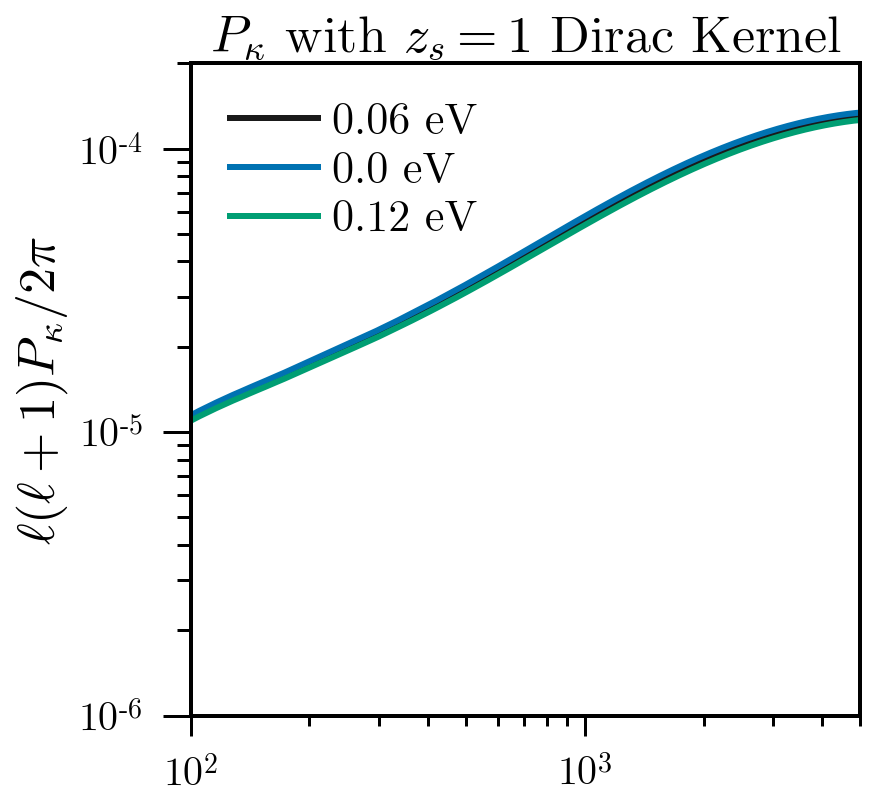

In [37]:
plt.figure(figsize=(6,6))

ell = np.arange(5000+1)
pref = 0.25 * (ell+2) * (ell+1) * (ell) * (ell-1)

cls_fid = obs.cosmos['CLASS_fiducial'].density_cl()
PS_fid = pref * cls_fid['ll'][0]

cls_left = obs.cosmos['m_ncdm_CLASS_left'].density_cl()
PS_left = pref * cls_left['ll'][0]
cls_right = obs.cosmos['m_ncdm_CLASS_right'].density_cl()
PS_right = pref * cls_right['ll'][0]
# filt = cls['ell'] > 300

pref2 = ell * (ell+1) / (2. * np.pi)
plt.plot( ell,(pref2 * PS_fid), '-', label='0.06 eV' )
plt.plot( ell,(pref2 * PS_left), '-', label='0.0 eV' )
plt.plot( ell,(pref2 * PS_right), '-', label='0.12 eV' )
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e2,5e3)

plt.ylabel(r'$\ell (\ell+1) P_{\kappa} / 2 \pi$')
plt.ylim(1e-6,2e-4)
plt.legend()
plt.title('$P_{\kappa}$ with $z_s=1$ Dirac Kernel');

It's important to point out that this plot looks the way it does at the small scale because of `halofit`. The signal is very small, so let's divide by the fiducial to see what's going on.

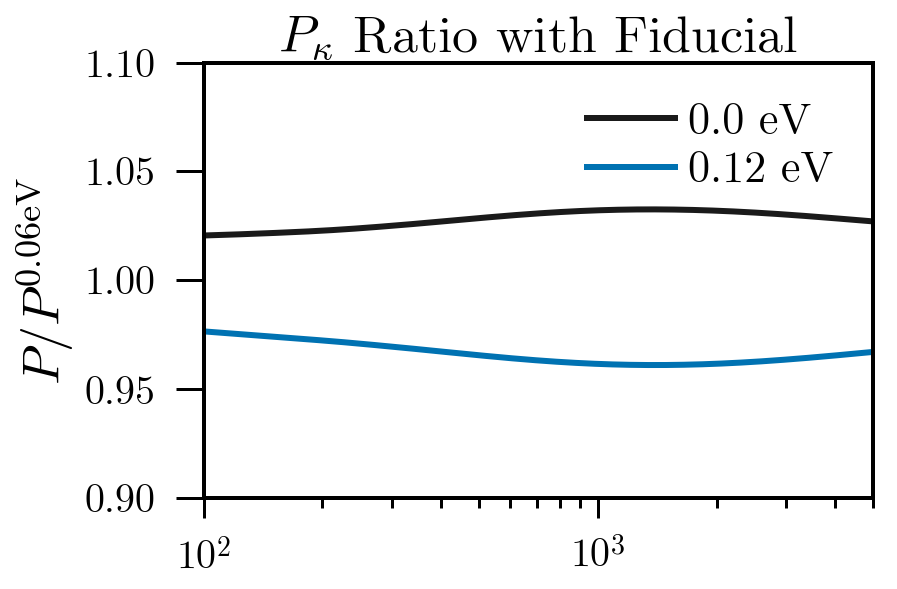

In [39]:
PS_fid[PS_fid==0.0] = 1.0 # avoid divide by zero for l=0, l=1 bins
plt.plot( ell, (PS_left/PS_fid), '-', label='0.0 eV' )
plt.plot( ell, (PS_right/PS_fid), '-', label='0.12 eV' )

# plt.yscale('log')
plt.xscale('log')
plt.xlim(1e2,5e3)

plt.ylabel(r'$ P / P^{\mathrm{0.06eV}}$')
plt.ylim(0.9, 1.1)
plt.legend()
plt.title('$P_{\kappa}$ Ratio with Fiducial');

As expected, a higher neutrino mass suppresses the lensing power spectrum. 

Now we want to calculate the Fisher matrix.

# Writing an Experiment Class

We'll now write a simple, single-redshift bin experiment. Note that (Kaiser 1992, 1998, Hu 1999) for redshift bins $i,j$,

$$ C_{ij}(\ell) = P_{\kappa}(\ell) + \delta_{ij} \frac{\sigma_e^2}{\bar{n}_i}$$

Then

$$F_{\alpha \beta} = \sum_{\ell=2}^{\ell_{max}} (\ell + 1/2) f_{sky} \mathrm{tr} \left[ \mathbf{C}^{-1} \mathbf{C}_{,\alpha} \mathbf{C}^{-1} \mathbf{C}_{,\beta} \right]$$

Since we are working with small changes in cosmology (i.e. we assume things are basically $\Lambda CDM$), the derivatives $\mathbf{C}_{,\alpha}$ only include $P_{\kappa}$. That is, the noise remains stable with changes to cosmology. 



In [32]:
import itertools

class SingleRedshiftGalaxyLensing(Experiment):
    """An experiment which has a delta function source plane."""
    
    def __init__(self, fsky, ngal, sigma_e, l_min, l_max):
        """Get the required noise properties of the experiment.
        
        Parameters
        ----------
            fsky (float) : sky fraction
            ngal (float) : number density of galaxies per steradian
            sigma_e (float) : galaxy shape noise parameter
            l_min (int) : minimum ell bin
            l_max (int) : maximum ell bin
        
        """
        self.fsky = fsky
        self.ngal = ngal
        self.sigma_e = sigma_e
        self.l_min = l_min
        self.l_max = l_max
        
    def get_Pkappa(self, cosmo, source_plane_index=0):
        """
        Extract the convergence power spectrum from a CLASS object.
        
        This utility function is required because CLASS's `ll` output
        corresponds to the lensing potential power spectrum, which must
        be converted to the lensing convergence/sheer power spectrum with 
        a factor of (ell+2)! / (ell-2)! / 4.
        
        Parameters
        ----------
            cosmo (CLASS wrapper object) : a computed CLASS cosmology
            source_plane_index (integer) : there can be multiple source
                planes, this parameter specifies which one.
        
        Returns
        -------
            numpy array : contains the convergence power spectrum 
        
        """
        cl = cosmo.density_cl()
        ell = cl['ell']
        pref = 0.25 * (ell+2) * (ell+1) * (ell) * (ell-1)
        convergencePS = pref * cl['ll'][source_plane_index]
        return convergencePS

    def get_fisher(self, obs):
        """Compute the Fisher matrix."""
        npar = len(obs.parameters)
        self.fisher = np.zeros((npar, npar))
        
        fid_kappa = self.get_Pkappa(obs.cosmos['CLASS_fiducial'])
        # compute derivatives for each parameter
        dCl = [(self.get_Pkappa(obs.cosmos[obs.parameters[i] + '_CLASS_right'])-
               self.get_Pkappa(obs.cosmos[obs.parameters[i] + '_CLASS_left']))
               /(obs.right[i] - obs.left[i]) for i in range(npar)]
        self.fisher_ell = np.zeros(self.l_max)
        
        for i, j in itertools.combinations_with_replacement(range(npar), r=2):
            # compute covariance matrix
            fisher_sum = 0.0
            for l in range(self.l_min, self.l_max):
                Cmat = np.array([[fid_kappa[l] + self.sigma_e**2/self.ngal]])
                invC = np.linalg.inv(Cmat)
                term = np.dot(np.dot(invC,dCl[i][l]),
                           np.dot(invC,dCl[j][l]))
                summand = (l+0.5) * self.fsky * np.trace(term)
                
                fisher_sum += summand
                if i == j and obs.parameters[i] == 'm_ncdm':
                    self.fisher_ell[l] += summand

            self.fisher[i, j] = fisher_sum
            self.fisher[j, i] = fisher_sum
                
        return self.fisher
            

We'll use something resembling LSST, so that $f_{sky} = 0.4$, $\sigma_e = 0.3$, and 40 galaxies per square degree. 

In [33]:
Planck = CMB_Primary()
exp = SingleRedshiftGalaxyLensing(fsky=0.4, ngal=40*3437.75**2, 
                                  sigma_e=0.35, l_min=80, l_max=3000)
fisher = exp.get_fisher(obs) #+ Planck.get_fisher(obs)

generating new axis
['$\\mathrm{A\\_s}$', '$\\mathrm{omega\\_cdm}$', '$\\mathrm{m\\_ncdm}$']


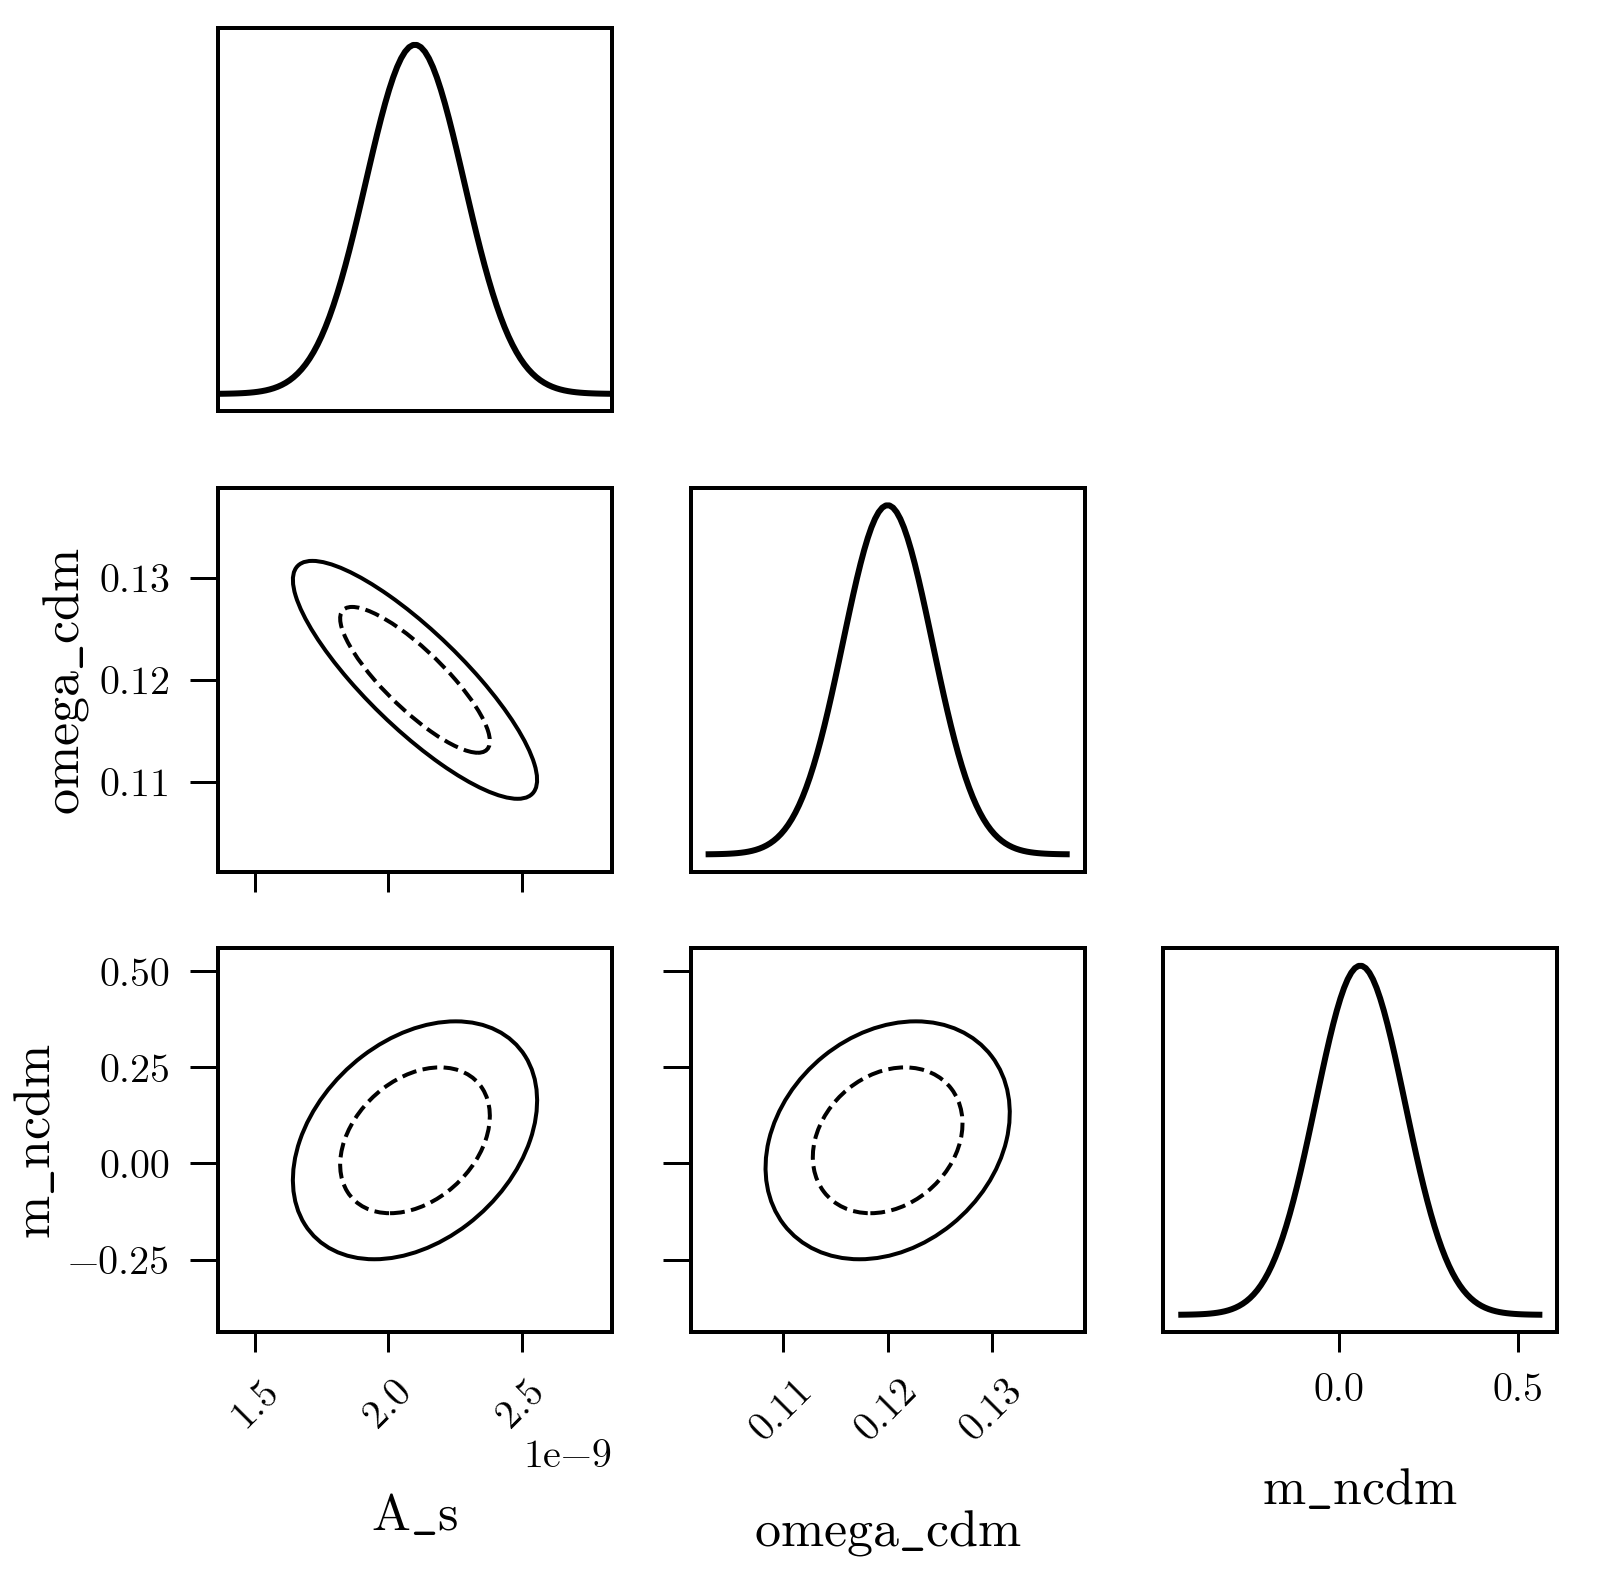

In [34]:
cov = np.linalg.inv(fisher)
fishchips.util.plot_triangle(obs, cov);

In [35]:
np.sqrt(cov[-1,-1])

0.1245973160264922